### Generate Image for Fashion MNIST dataset

- Fix Keras version check
- Imports
- See data
- Create global variables
- Create functions (build model, build discriminator, show images, train model)
- Execute each function
- Show some images genarations examples

In [1]:
##https://github.com/h5py/h5py/issues/853
import os ; 
os.environ['HDF5_DISABLE_VERSION_CHECK']='1'

In [2]:

from keras.datasets import fashion_mnist

import keras
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model

import matplotlib.pyplot as plt
import sys
import numpy as np


D:\Programas\Anaconda3\lib\site-packages\h5py\__init__.py:75: UserWarning: h5py is running against HDF5 1.10.5 when it was built against 1.10.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

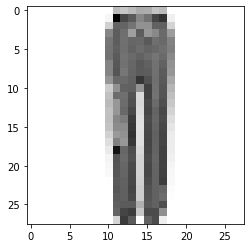

In [4]:
plt.imshow(x_train[1000], cmap='Greys')

In [5]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [6]:
def build_generator():

        model = Sequential()

        model.add(Dense(256, input_dim=latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(img_shape), activation='tanh'))
        model.add(Reshape(img_shape))

        model.summary()

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

In [7]:
 def build_discriminator():

        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

In [8]:
def sample_images(epoch=0, save=0):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if save :
            fig.savefig("assets/generate_mnist_%d.png" % epoch)
        plt.show()
        plt.close()

In [9]:
def save_original_dataset_imgs():
        r, c = 5, 5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(x_train[cnt], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("assets/mnist_0.png")
        plt.close()

In [10]:
 def train(epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Generate a batch of new images
            gen_imgs = generator.predict(noise)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                sample_images(epoch)

### GAN start process
![image info](./assets/gan_schema.png)
Credit: O’Reilly

In [11]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
z = Input(shape=(100,))
img = generator(z)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
__________

In [12]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [13]:
validity = discriminator(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))

D:\Programas\Anaconda3\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.922810, acc.: 20.31%] [G loss: 0.634202]


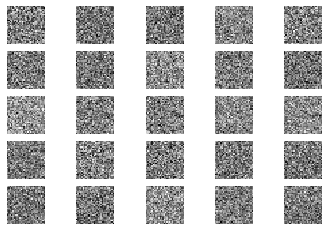

1 [D loss: 0.480880, acc.: 78.12%] [G loss: 0.639349]
2 [D loss: 0.379256, acc.: 79.69%] [G loss: 0.670428]
3 [D loss: 0.356765, acc.: 81.25%] [G loss: 0.690830]
4 [D loss: 0.329218, acc.: 87.50%] [G loss: 0.811963]
5 [D loss: 0.293486, acc.: 92.19%] [G loss: 0.866277]
6 [D loss: 0.267577, acc.: 96.88%] [G loss: 0.958518]
7 [D loss: 0.269327, acc.: 98.44%] [G loss: 1.145592]
8 [D loss: 0.203688, acc.: 100.00%] [G loss: 1.341381]
9 [D loss: 0.190555, acc.: 100.00%] [G loss: 1.495005]
10 [D loss: 0.171687, acc.: 98.44%] [G loss: 1.616035]
11 [D loss: 0.126713, acc.: 100.00%] [G loss: 1.737288]
12 [D loss: 0.130163, acc.: 100.00%] [G loss: 1.750927]
13 [D loss: 0.116502, acc.: 100.00%] [G loss: 1.975447]
14 [D loss: 0.112908, acc.: 100.00%] [G loss: 2.062573]
15 [D loss: 0.088101, acc.: 100.00%] [G loss: 2.342783]
16 [D loss: 0.075869, acc.: 100.00%] [G loss: 2.319221]
17 [D loss: 0.078533, acc.: 100.00%] [G loss: 2.492915]
18 [D loss: 0.070246, acc.: 100.00%] [G loss: 2.532311]
19 [D los

148 [D loss: 0.007171, acc.: 100.00%] [G loss: 5.249652]
149 [D loss: 0.005191, acc.: 100.00%] [G loss: 5.272872]
150 [D loss: 0.005761, acc.: 100.00%] [G loss: 5.208961]
151 [D loss: 0.009125, acc.: 100.00%] [G loss: 5.376682]
152 [D loss: 0.014390, acc.: 100.00%] [G loss: 5.284825]
153 [D loss: 0.003790, acc.: 100.00%] [G loss: 5.219735]
154 [D loss: 0.005645, acc.: 100.00%] [G loss: 5.337651]
155 [D loss: 0.005892, acc.: 100.00%] [G loss: 5.261785]
156 [D loss: 0.005443, acc.: 100.00%] [G loss: 5.395726]
157 [D loss: 0.004101, acc.: 100.00%] [G loss: 5.360491]
158 [D loss: 0.004243, acc.: 100.00%] [G loss: 5.235921]
159 [D loss: 0.007216, acc.: 100.00%] [G loss: 5.278789]
160 [D loss: 0.008496, acc.: 100.00%] [G loss: 5.277890]
161 [D loss: 0.005411, acc.: 100.00%] [G loss: 5.311393]
162 [D loss: 0.004495, acc.: 100.00%] [G loss: 5.476677]
163 [D loss: 0.003557, acc.: 100.00%] [G loss: 5.415063]
164 [D loss: 0.005568, acc.: 100.00%] [G loss: 5.421095]
165 [D loss: 0.007085, acc.: 10

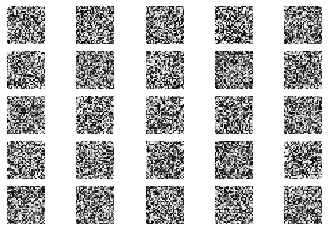

201 [D loss: 0.035946, acc.: 98.44%] [G loss: 5.426578]
202 [D loss: 0.012448, acc.: 100.00%] [G loss: 5.453278]
203 [D loss: 0.011674, acc.: 100.00%] [G loss: 5.580648]
204 [D loss: 0.006934, acc.: 100.00%] [G loss: 5.564048]
205 [D loss: 0.007811, acc.: 100.00%] [G loss: 5.885794]
206 [D loss: 0.004719, acc.: 100.00%] [G loss: 5.723651]
207 [D loss: 0.006391, acc.: 100.00%] [G loss: 5.552163]
208 [D loss: 0.004215, acc.: 100.00%] [G loss: 5.644720]
209 [D loss: 0.004647, acc.: 100.00%] [G loss: 5.755955]
210 [D loss: 0.003434, acc.: 100.00%] [G loss: 5.410644]
211 [D loss: 0.005972, acc.: 100.00%] [G loss: 5.510273]
212 [D loss: 0.006112, acc.: 100.00%] [G loss: 5.641378]
213 [D loss: 0.006570, acc.: 100.00%] [G loss: 5.514781]
214 [D loss: 0.004333, acc.: 100.00%] [G loss: 5.809478]
215 [D loss: 0.007311, acc.: 100.00%] [G loss: 5.781865]
216 [D loss: 0.009689, acc.: 100.00%] [G loss: 5.668010]
217 [D loss: 0.006720, acc.: 100.00%] [G loss: 5.652901]
218 [D loss: 0.006261, acc.: 100

347 [D loss: 0.109331, acc.: 96.88%] [G loss: 4.977630]
348 [D loss: 0.021407, acc.: 100.00%] [G loss: 5.243382]
349 [D loss: 0.047223, acc.: 98.44%] [G loss: 5.128639]
350 [D loss: 0.033801, acc.: 98.44%] [G loss: 5.028781]
351 [D loss: 0.062943, acc.: 98.44%] [G loss: 4.642855]
352 [D loss: 0.060297, acc.: 100.00%] [G loss: 4.741442]
353 [D loss: 0.015910, acc.: 100.00%] [G loss: 5.616421]
354 [D loss: 0.133173, acc.: 98.44%] [G loss: 4.629325]
355 [D loss: 0.063648, acc.: 98.44%] [G loss: 4.915848]
356 [D loss: 0.027578, acc.: 100.00%] [G loss: 5.271228]
357 [D loss: 0.019308, acc.: 100.00%] [G loss: 5.148355]
358 [D loss: 0.088653, acc.: 95.31%] [G loss: 5.594834]
359 [D loss: 0.067553, acc.: 96.88%] [G loss: 5.690016]
360 [D loss: 0.058027, acc.: 100.00%] [G loss: 5.200159]
361 [D loss: 0.021148, acc.: 100.00%] [G loss: 5.291251]
362 [D loss: 0.038334, acc.: 98.44%] [G loss: 5.980043]
363 [D loss: 0.041588, acc.: 98.44%] [G loss: 6.031714]
364 [D loss: 0.025081, acc.: 100.00%] [G 

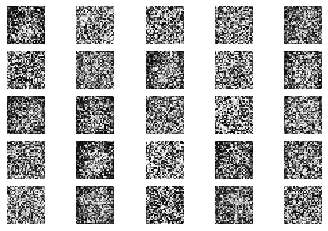

401 [D loss: 0.037586, acc.: 100.00%] [G loss: 6.181436]
402 [D loss: 0.016897, acc.: 100.00%] [G loss: 5.547314]
403 [D loss: 0.168181, acc.: 93.75%] [G loss: 5.227694]
404 [D loss: 0.011349, acc.: 100.00%] [G loss: 5.745951]
405 [D loss: 0.086074, acc.: 95.31%] [G loss: 5.203948]
406 [D loss: 0.027418, acc.: 100.00%] [G loss: 5.820230]
407 [D loss: 0.028218, acc.: 100.00%] [G loss: 6.373561]
408 [D loss: 0.083349, acc.: 96.88%] [G loss: 5.758289]
409 [D loss: 0.025469, acc.: 98.44%] [G loss: 5.623815]
410 [D loss: 0.019578, acc.: 100.00%] [G loss: 5.529717]
411 [D loss: 0.051215, acc.: 96.88%] [G loss: 5.353920]
412 [D loss: 0.069198, acc.: 98.44%] [G loss: 5.499945]
413 [D loss: 0.093060, acc.: 98.44%] [G loss: 5.414932]
414 [D loss: 0.027340, acc.: 100.00%] [G loss: 5.732576]
415 [D loss: 0.043251, acc.: 98.44%] [G loss: 5.743876]
416 [D loss: 0.216319, acc.: 90.62%] [G loss: 5.578880]
417 [D loss: 0.020836, acc.: 100.00%] [G loss: 5.863700]
418 [D loss: 0.047378, acc.: 98.44%] [G 

549 [D loss: 0.100674, acc.: 96.88%] [G loss: 4.619855]
550 [D loss: 0.082136, acc.: 96.88%] [G loss: 4.948014]
551 [D loss: 0.144811, acc.: 95.31%] [G loss: 3.776140]
552 [D loss: 0.088745, acc.: 96.88%] [G loss: 4.573934]
553 [D loss: 0.142361, acc.: 93.75%] [G loss: 3.589090]
554 [D loss: 0.126874, acc.: 95.31%] [G loss: 5.231841]
555 [D loss: 0.174020, acc.: 96.88%] [G loss: 4.215004]
556 [D loss: 0.182154, acc.: 95.31%] [G loss: 4.114381]
557 [D loss: 0.133935, acc.: 93.75%] [G loss: 5.301584]
558 [D loss: 0.282350, acc.: 87.50%] [G loss: 4.621234]
559 [D loss: 0.178368, acc.: 95.31%] [G loss: 4.315298]
560 [D loss: 0.298695, acc.: 92.19%] [G loss: 4.104060]
561 [D loss: 0.119550, acc.: 95.31%] [G loss: 3.970174]
562 [D loss: 0.249167, acc.: 87.50%] [G loss: 5.123005]
563 [D loss: 0.161911, acc.: 98.44%] [G loss: 4.599509]
564 [D loss: 0.307176, acc.: 92.19%] [G loss: 4.134114]
565 [D loss: 0.299098, acc.: 93.75%] [G loss: 3.375943]
566 [D loss: 0.094733, acc.: 95.31%] [G loss: 4.

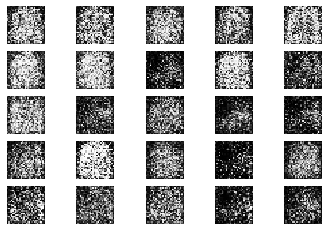

601 [D loss: 0.514967, acc.: 76.56%] [G loss: 2.742717]
602 [D loss: 0.138896, acc.: 95.31%] [G loss: 4.376935]
603 [D loss: 0.220286, acc.: 90.62%] [G loss: 3.162540]
604 [D loss: 0.136027, acc.: 98.44%] [G loss: 4.010518]
605 [D loss: 0.271782, acc.: 90.62%] [G loss: 3.435402]
606 [D loss: 0.125188, acc.: 92.19%] [G loss: 3.418900]
607 [D loss: 0.257482, acc.: 90.62%] [G loss: 3.359730]
608 [D loss: 0.284843, acc.: 84.38%] [G loss: 3.560285]
609 [D loss: 0.241375, acc.: 96.88%] [G loss: 3.700329]
610 [D loss: 0.242311, acc.: 87.50%] [G loss: 3.784429]
611 [D loss: 0.184154, acc.: 92.19%] [G loss: 3.323309]
612 [D loss: 0.242651, acc.: 92.19%] [G loss: 3.064658]
613 [D loss: 0.182985, acc.: 93.75%] [G loss: 3.730235]
614 [D loss: 0.382541, acc.: 82.81%] [G loss: 3.240513]
615 [D loss: 0.172424, acc.: 93.75%] [G loss: 3.659078]
616 [D loss: 0.167910, acc.: 92.19%] [G loss: 4.553061]
617 [D loss: 0.261266, acc.: 90.62%] [G loss: 3.055553]
618 [D loss: 0.271118, acc.: 82.81%] [G loss: 4.

747 [D loss: 0.156374, acc.: 100.00%] [G loss: 3.082434]
748 [D loss: 0.501949, acc.: 79.69%] [G loss: 1.732290]
749 [D loss: 0.645142, acc.: 68.75%] [G loss: 2.069438]
750 [D loss: 0.371027, acc.: 92.19%] [G loss: 2.441422]
751 [D loss: 0.292799, acc.: 90.62%] [G loss: 2.285935]
752 [D loss: 0.287840, acc.: 84.38%] [G loss: 2.606323]
753 [D loss: 0.518171, acc.: 87.50%] [G loss: 2.132849]
754 [D loss: 0.494379, acc.: 79.69%] [G loss: 2.139287]
755 [D loss: 0.762775, acc.: 60.94%] [G loss: 2.190166]
756 [D loss: 0.361937, acc.: 87.50%] [G loss: 2.646954]
757 [D loss: 0.654989, acc.: 70.31%] [G loss: 1.797753]
758 [D loss: 0.530710, acc.: 71.88%] [G loss: 2.312188]
759 [D loss: 0.289872, acc.: 92.19%] [G loss: 2.771581]
760 [D loss: 0.376360, acc.: 89.06%] [G loss: 2.032851]
761 [D loss: 0.309299, acc.: 93.75%] [G loss: 2.258866]
762 [D loss: 0.216009, acc.: 95.31%] [G loss: 2.347145]
763 [D loss: 0.220155, acc.: 96.88%] [G loss: 2.462703]
764 [D loss: 0.526243, acc.: 79.69%] [G loss: 1

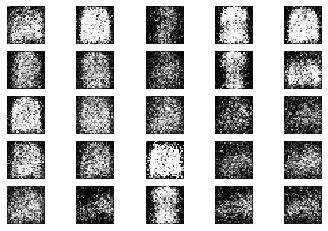

801 [D loss: 0.458567, acc.: 78.12%] [G loss: 2.198464]
802 [D loss: 0.300748, acc.: 89.06%] [G loss: 2.497790]
803 [D loss: 0.376248, acc.: 85.94%] [G loss: 1.767219]
804 [D loss: 0.359667, acc.: 85.94%] [G loss: 2.123958]
805 [D loss: 0.398287, acc.: 89.06%] [G loss: 2.577773]
806 [D loss: 0.395184, acc.: 85.94%] [G loss: 2.173345]
807 [D loss: 0.427890, acc.: 87.50%] [G loss: 2.172452]
808 [D loss: 0.335473, acc.: 93.75%] [G loss: 2.137083]
809 [D loss: 0.515280, acc.: 82.81%] [G loss: 1.828856]
810 [D loss: 0.517576, acc.: 81.25%] [G loss: 1.977908]
811 [D loss: 0.483068, acc.: 85.94%] [G loss: 2.020460]
812 [D loss: 0.394667, acc.: 87.50%] [G loss: 2.151787]
813 [D loss: 0.416265, acc.: 87.50%] [G loss: 1.981108]
814 [D loss: 0.330173, acc.: 85.94%] [G loss: 2.559652]
815 [D loss: 0.560584, acc.: 81.25%] [G loss: 2.092691]
816 [D loss: 0.457107, acc.: 81.25%] [G loss: 1.969004]
817 [D loss: 0.432192, acc.: 87.50%] [G loss: 2.356220]
818 [D loss: 0.478272, acc.: 78.12%] [G loss: 1.

948 [D loss: 0.515449, acc.: 78.12%] [G loss: 1.348157]
949 [D loss: 0.381476, acc.: 79.69%] [G loss: 1.600869]
950 [D loss: 0.463304, acc.: 81.25%] [G loss: 1.532670]
951 [D loss: 0.443005, acc.: 81.25%] [G loss: 1.590424]
952 [D loss: 0.446505, acc.: 84.38%] [G loss: 1.548904]
953 [D loss: 0.421939, acc.: 82.81%] [G loss: 1.855064]
954 [D loss: 0.521215, acc.: 78.12%] [G loss: 1.545925]
955 [D loss: 0.468003, acc.: 84.38%] [G loss: 1.528173]
956 [D loss: 0.383410, acc.: 89.06%] [G loss: 1.669210]
957 [D loss: 0.456721, acc.: 85.94%] [G loss: 1.826829]
958 [D loss: 0.452926, acc.: 82.81%] [G loss: 1.624211]
959 [D loss: 0.383420, acc.: 82.81%] [G loss: 1.810256]
960 [D loss: 0.487231, acc.: 79.69%] [G loss: 1.280246]
961 [D loss: 0.356206, acc.: 85.94%] [G loss: 1.557878]
962 [D loss: 0.471501, acc.: 76.56%] [G loss: 1.493743]
963 [D loss: 0.518168, acc.: 78.12%] [G loss: 1.549585]
964 [D loss: 0.330124, acc.: 89.06%] [G loss: 1.606591]
965 [D loss: 0.399186, acc.: 82.81%] [G loss: 1.

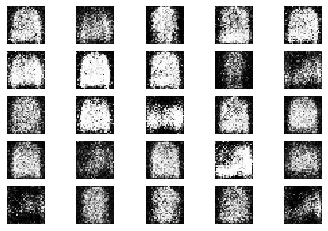

1001 [D loss: 0.450221, acc.: 79.69%] [G loss: 1.396015]
1002 [D loss: 0.464796, acc.: 82.81%] [G loss: 1.542726]
1003 [D loss: 0.506937, acc.: 78.12%] [G loss: 1.682061]
1004 [D loss: 0.369858, acc.: 89.06%] [G loss: 1.775158]
1005 [D loss: 0.488606, acc.: 78.12%] [G loss: 1.718144]
1006 [D loss: 0.513169, acc.: 75.00%] [G loss: 1.685680]
1007 [D loss: 0.444577, acc.: 85.94%] [G loss: 1.689275]
1008 [D loss: 0.503685, acc.: 73.44%] [G loss: 1.455724]
1009 [D loss: 0.328090, acc.: 90.62%] [G loss: 1.850712]
1010 [D loss: 0.343732, acc.: 90.62%] [G loss: 1.866765]
1011 [D loss: 0.523214, acc.: 78.12%] [G loss: 1.543853]
1012 [D loss: 0.402137, acc.: 81.25%] [G loss: 1.604069]
1013 [D loss: 0.403558, acc.: 82.81%] [G loss: 1.593208]
1014 [D loss: 0.456958, acc.: 81.25%] [G loss: 1.558622]
1015 [D loss: 0.619266, acc.: 62.50%] [G loss: 1.361294]
1016 [D loss: 0.429338, acc.: 75.00%] [G loss: 1.546347]
1017 [D loss: 0.439796, acc.: 84.38%] [G loss: 1.389247]
1018 [D loss: 0.413010, acc.: 7

1147 [D loss: 0.428982, acc.: 79.69%] [G loss: 1.642477]
1148 [D loss: 0.485605, acc.: 76.56%] [G loss: 1.454273]
1149 [D loss: 0.438845, acc.: 82.81%] [G loss: 1.526136]
1150 [D loss: 0.283092, acc.: 89.06%] [G loss: 1.656611]
1151 [D loss: 0.370239, acc.: 85.94%] [G loss: 1.345890]
1152 [D loss: 0.435739, acc.: 82.81%] [G loss: 1.603362]
1153 [D loss: 0.564119, acc.: 76.56%] [G loss: 1.670854]
1154 [D loss: 0.516532, acc.: 76.56%] [G loss: 1.595363]
1155 [D loss: 0.512990, acc.: 70.31%] [G loss: 1.581941]
1156 [D loss: 0.529701, acc.: 79.69%] [G loss: 1.552276]
1157 [D loss: 0.310178, acc.: 93.75%] [G loss: 1.728184]
1158 [D loss: 0.426683, acc.: 81.25%] [G loss: 1.634583]
1159 [D loss: 0.455077, acc.: 75.00%] [G loss: 1.637811]
1160 [D loss: 0.478947, acc.: 76.56%] [G loss: 1.603187]
1161 [D loss: 0.509853, acc.: 75.00%] [G loss: 1.321665]
1162 [D loss: 0.497539, acc.: 73.44%] [G loss: 1.480682]
1163 [D loss: 0.444669, acc.: 79.69%] [G loss: 1.563316]
1164 [D loss: 0.429807, acc.: 8

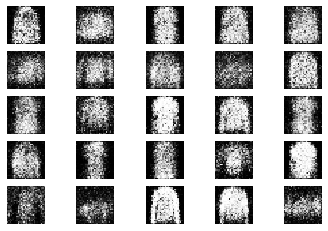

1201 [D loss: 0.412794, acc.: 82.81%] [G loss: 1.520426]
1202 [D loss: 0.362597, acc.: 84.38%] [G loss: 1.484267]
1203 [D loss: 0.380067, acc.: 84.38%] [G loss: 1.599623]
1204 [D loss: 0.599385, acc.: 68.75%] [G loss: 1.805450]
1205 [D loss: 0.449944, acc.: 81.25%] [G loss: 1.845387]
1206 [D loss: 0.442849, acc.: 81.25%] [G loss: 1.818137]
1207 [D loss: 0.557528, acc.: 75.00%] [G loss: 1.512800]
1208 [D loss: 0.536866, acc.: 73.44%] [G loss: 1.430863]
1209 [D loss: 0.413054, acc.: 81.25%] [G loss: 1.501521]
1210 [D loss: 0.548491, acc.: 71.88%] [G loss: 1.633114]
1211 [D loss: 0.388107, acc.: 89.06%] [G loss: 1.593235]
1212 [D loss: 0.477806, acc.: 78.12%] [G loss: 1.355521]
1213 [D loss: 0.434151, acc.: 84.38%] [G loss: 1.558277]
1214 [D loss: 0.487966, acc.: 75.00%] [G loss: 1.455005]
1215 [D loss: 0.460503, acc.: 78.12%] [G loss: 1.620476]
1216 [D loss: 0.509494, acc.: 81.25%] [G loss: 1.405696]
1217 [D loss: 0.391151, acc.: 81.25%] [G loss: 1.436566]
1218 [D loss: 0.691788, acc.: 6

1346 [D loss: 0.452525, acc.: 75.00%] [G loss: 1.445326]
1347 [D loss: 0.479321, acc.: 78.12%] [G loss: 1.556533]
1348 [D loss: 0.412572, acc.: 76.56%] [G loss: 1.507635]
1349 [D loss: 0.486365, acc.: 75.00%] [G loss: 1.672395]
1350 [D loss: 0.473799, acc.: 82.81%] [G loss: 1.512497]
1351 [D loss: 0.447477, acc.: 78.12%] [G loss: 1.288236]
1352 [D loss: 0.416572, acc.: 84.38%] [G loss: 1.143616]
1353 [D loss: 0.520586, acc.: 71.88%] [G loss: 1.594253]
1354 [D loss: 0.443613, acc.: 75.00%] [G loss: 1.730961]
1355 [D loss: 0.493117, acc.: 75.00%] [G loss: 1.491930]
1356 [D loss: 0.516271, acc.: 71.88%] [G loss: 1.461435]
1357 [D loss: 0.485771, acc.: 71.88%] [G loss: 1.324270]
1358 [D loss: 0.534136, acc.: 76.56%] [G loss: 1.400541]
1359 [D loss: 0.461551, acc.: 76.56%] [G loss: 1.491295]
1360 [D loss: 0.492601, acc.: 78.12%] [G loss: 1.334286]
1361 [D loss: 0.523991, acc.: 76.56%] [G loss: 1.583020]
1362 [D loss: 0.570335, acc.: 73.44%] [G loss: 1.378226]
1363 [D loss: 0.420294, acc.: 8

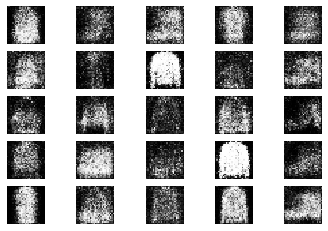

1401 [D loss: 0.384061, acc.: 85.94%] [G loss: 1.421448]
1402 [D loss: 0.580666, acc.: 68.75%] [G loss: 1.594499]
1403 [D loss: 0.560408, acc.: 73.44%] [G loss: 1.431595]
1404 [D loss: 0.494914, acc.: 70.31%] [G loss: 1.661559]
1405 [D loss: 0.579934, acc.: 75.00%] [G loss: 1.367764]
1406 [D loss: 0.575395, acc.: 68.75%] [G loss: 1.588036]
1407 [D loss: 0.585343, acc.: 70.31%] [G loss: 1.670809]
1408 [D loss: 0.585242, acc.: 71.88%] [G loss: 1.329966]
1409 [D loss: 0.700249, acc.: 56.25%] [G loss: 1.437165]
1410 [D loss: 0.517172, acc.: 71.88%] [G loss: 1.587464]
1411 [D loss: 0.620855, acc.: 68.75%] [G loss: 1.544689]
1412 [D loss: 0.539168, acc.: 73.44%] [G loss: 1.481355]
1413 [D loss: 0.423908, acc.: 84.38%] [G loss: 1.596406]
1414 [D loss: 0.570437, acc.: 76.56%] [G loss: 1.244126]
1415 [D loss: 0.577317, acc.: 71.88%] [G loss: 1.347119]
1416 [D loss: 0.634426, acc.: 68.75%] [G loss: 1.549967]
1417 [D loss: 0.508801, acc.: 73.44%] [G loss: 1.554453]
1418 [D loss: 0.582636, acc.: 6

1544 [D loss: 0.370012, acc.: 85.94%] [G loss: 1.458527]
1545 [D loss: 0.429090, acc.: 82.81%] [G loss: 1.505983]
1546 [D loss: 0.509091, acc.: 75.00%] [G loss: 1.394375]
1547 [D loss: 0.563685, acc.: 73.44%] [G loss: 1.340603]
1548 [D loss: 0.393616, acc.: 84.38%] [G loss: 1.598619]
1549 [D loss: 0.488191, acc.: 79.69%] [G loss: 1.640567]
1550 [D loss: 0.565256, acc.: 75.00%] [G loss: 1.476186]
1551 [D loss: 0.593990, acc.: 71.88%] [G loss: 1.540862]
1552 [D loss: 0.529077, acc.: 68.75%] [G loss: 1.276702]
1553 [D loss: 0.519834, acc.: 73.44%] [G loss: 1.396011]
1554 [D loss: 0.550715, acc.: 76.56%] [G loss: 1.445794]
1555 [D loss: 0.490777, acc.: 75.00%] [G loss: 1.388232]
1556 [D loss: 0.472104, acc.: 76.56%] [G loss: 1.460355]
1557 [D loss: 0.467784, acc.: 81.25%] [G loss: 1.448059]
1558 [D loss: 0.629839, acc.: 65.62%] [G loss: 1.456314]
1559 [D loss: 0.539861, acc.: 79.69%] [G loss: 1.300360]
1560 [D loss: 0.524690, acc.: 67.19%] [G loss: 1.185578]
1561 [D loss: 0.485184, acc.: 7

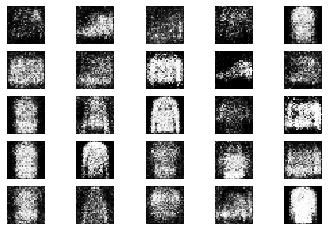

1601 [D loss: 0.496139, acc.: 76.56%] [G loss: 1.455339]
1602 [D loss: 0.452904, acc.: 73.44%] [G loss: 1.453170]
1603 [D loss: 0.522092, acc.: 75.00%] [G loss: 1.631732]
1604 [D loss: 0.513457, acc.: 75.00%] [G loss: 1.467473]
1605 [D loss: 0.557162, acc.: 73.44%] [G loss: 1.430823]
1606 [D loss: 0.565050, acc.: 65.62%] [G loss: 1.394804]
1607 [D loss: 0.464479, acc.: 82.81%] [G loss: 1.323877]
1608 [D loss: 0.490757, acc.: 76.56%] [G loss: 1.346935]
1609 [D loss: 0.556722, acc.: 67.19%] [G loss: 1.065717]
1610 [D loss: 0.418398, acc.: 79.69%] [G loss: 1.189451]
1611 [D loss: 0.465240, acc.: 81.25%] [G loss: 1.432064]
1612 [D loss: 0.490269, acc.: 75.00%] [G loss: 1.499830]
1613 [D loss: 0.518583, acc.: 76.56%] [G loss: 1.424313]
1614 [D loss: 0.416999, acc.: 81.25%] [G loss: 1.423244]
1615 [D loss: 0.458124, acc.: 76.56%] [G loss: 1.496812]
1616 [D loss: 0.495724, acc.: 73.44%] [G loss: 1.376281]
1617 [D loss: 0.474306, acc.: 78.12%] [G loss: 1.224539]
1618 [D loss: 0.536907, acc.: 7

1746 [D loss: 0.523715, acc.: 67.19%] [G loss: 1.184037]
1747 [D loss: 0.496744, acc.: 79.69%] [G loss: 1.187004]
1748 [D loss: 0.467094, acc.: 76.56%] [G loss: 1.246184]
1749 [D loss: 0.581158, acc.: 65.62%] [G loss: 1.097850]
1750 [D loss: 0.451106, acc.: 84.38%] [G loss: 1.341704]
1751 [D loss: 0.450994, acc.: 79.69%] [G loss: 1.292166]
1752 [D loss: 0.506076, acc.: 73.44%] [G loss: 1.169920]
1753 [D loss: 0.506521, acc.: 75.00%] [G loss: 1.380571]
1754 [D loss: 0.628654, acc.: 71.88%] [G loss: 1.512090]
1755 [D loss: 0.511223, acc.: 73.44%] [G loss: 1.355762]
1756 [D loss: 0.577546, acc.: 67.19%] [G loss: 1.240270]
1757 [D loss: 0.553246, acc.: 73.44%] [G loss: 1.301080]
1758 [D loss: 0.451243, acc.: 78.12%] [G loss: 1.266126]
1759 [D loss: 0.535303, acc.: 68.75%] [G loss: 1.164608]
1760 [D loss: 0.614067, acc.: 68.75%] [G loss: 1.096514]
1761 [D loss: 0.567679, acc.: 71.88%] [G loss: 1.187190]
1762 [D loss: 0.540658, acc.: 68.75%] [G loss: 1.193944]
1763 [D loss: 0.449170, acc.: 8

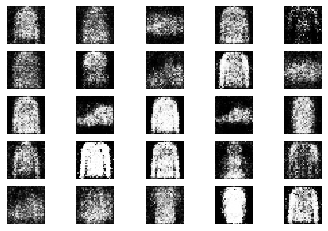

1801 [D loss: 0.585510, acc.: 67.19%] [G loss: 1.331811]
1802 [D loss: 0.571123, acc.: 68.75%] [G loss: 1.209676]
1803 [D loss: 0.423198, acc.: 81.25%] [G loss: 1.207669]
1804 [D loss: 0.514562, acc.: 71.88%] [G loss: 1.002122]
1805 [D loss: 0.504532, acc.: 68.75%] [G loss: 1.279337]
1806 [D loss: 0.531097, acc.: 76.56%] [G loss: 1.342838]
1807 [D loss: 0.585625, acc.: 70.31%] [G loss: 1.390542]
1808 [D loss: 0.614758, acc.: 70.31%] [G loss: 1.116281]
1809 [D loss: 0.609478, acc.: 67.19%] [G loss: 1.287071]
1810 [D loss: 0.493031, acc.: 78.12%] [G loss: 1.353815]
1811 [D loss: 0.476799, acc.: 79.69%] [G loss: 1.172544]
1812 [D loss: 0.569679, acc.: 73.44%] [G loss: 1.221092]
1813 [D loss: 0.492522, acc.: 76.56%] [G loss: 1.298152]
1814 [D loss: 0.532270, acc.: 73.44%] [G loss: 1.283589]
1815 [D loss: 0.413469, acc.: 81.25%] [G loss: 1.283410]
1816 [D loss: 0.585132, acc.: 71.88%] [G loss: 1.164642]
1817 [D loss: 0.541982, acc.: 64.06%] [G loss: 1.421246]
1818 [D loss: 0.515597, acc.: 7

1945 [D loss: 0.521631, acc.: 68.75%] [G loss: 1.327661]
1946 [D loss: 0.465323, acc.: 81.25%] [G loss: 1.251559]
1947 [D loss: 0.413440, acc.: 81.25%] [G loss: 1.193674]
1948 [D loss: 0.530287, acc.: 73.44%] [G loss: 1.342724]
1949 [D loss: 0.574881, acc.: 71.88%] [G loss: 1.289858]
1950 [D loss: 0.417050, acc.: 79.69%] [G loss: 1.437580]
1951 [D loss: 0.516600, acc.: 75.00%] [G loss: 1.157344]
1952 [D loss: 0.524590, acc.: 76.56%] [G loss: 1.354235]
1953 [D loss: 0.576594, acc.: 70.31%] [G loss: 1.312129]
1954 [D loss: 0.512908, acc.: 78.12%] [G loss: 1.005553]
1955 [D loss: 0.697331, acc.: 57.81%] [G loss: 1.170748]
1956 [D loss: 0.533237, acc.: 73.44%] [G loss: 1.110116]
1957 [D loss: 0.498519, acc.: 76.56%] [G loss: 1.250737]
1958 [D loss: 0.469370, acc.: 87.50%] [G loss: 1.154596]
1959 [D loss: 0.596168, acc.: 67.19%] [G loss: 1.279132]
1960 [D loss: 0.550239, acc.: 78.12%] [G loss: 1.227474]
1961 [D loss: 0.512448, acc.: 75.00%] [G loss: 1.229304]
1962 [D loss: 0.569163, acc.: 7

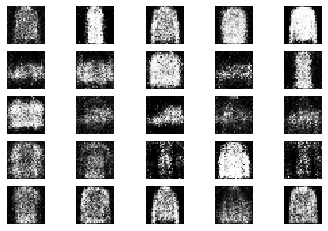

2001 [D loss: 0.458704, acc.: 85.94%] [G loss: 1.253691]
2002 [D loss: 0.465253, acc.: 81.25%] [G loss: 1.261750]
2003 [D loss: 0.524157, acc.: 78.12%] [G loss: 1.279633]
2004 [D loss: 0.581784, acc.: 70.31%] [G loss: 1.199062]
2005 [D loss: 0.504028, acc.: 70.31%] [G loss: 1.413981]
2006 [D loss: 0.405459, acc.: 90.62%] [G loss: 1.186730]
2007 [D loss: 0.566954, acc.: 75.00%] [G loss: 1.259468]
2008 [D loss: 0.668673, acc.: 60.94%] [G loss: 1.267866]
2009 [D loss: 0.565391, acc.: 76.56%] [G loss: 1.136458]
2010 [D loss: 0.561834, acc.: 67.19%] [G loss: 1.193403]
2011 [D loss: 0.573174, acc.: 67.19%] [G loss: 1.023546]
2012 [D loss: 0.462456, acc.: 81.25%] [G loss: 1.149391]
2013 [D loss: 0.517717, acc.: 76.56%] [G loss: 1.346550]
2014 [D loss: 0.500623, acc.: 73.44%] [G loss: 1.214137]
2015 [D loss: 0.443646, acc.: 82.81%] [G loss: 1.142838]
2016 [D loss: 0.536098, acc.: 73.44%] [G loss: 1.147891]
2017 [D loss: 0.467536, acc.: 84.38%] [G loss: 1.343564]
2018 [D loss: 0.485157, acc.: 7

2145 [D loss: 0.630679, acc.: 70.31%] [G loss: 1.208540]
2146 [D loss: 0.461951, acc.: 81.25%] [G loss: 1.290880]
2147 [D loss: 0.527717, acc.: 73.44%] [G loss: 1.099167]
2148 [D loss: 0.543322, acc.: 73.44%] [G loss: 1.347748]
2149 [D loss: 0.451482, acc.: 82.81%] [G loss: 1.315442]
2150 [D loss: 0.398776, acc.: 84.38%] [G loss: 1.370722]
2151 [D loss: 0.434438, acc.: 79.69%] [G loss: 1.250344]
2152 [D loss: 0.474710, acc.: 79.69%] [G loss: 1.354904]
2153 [D loss: 0.502706, acc.: 75.00%] [G loss: 1.148260]
2154 [D loss: 0.446121, acc.: 76.56%] [G loss: 1.383885]
2155 [D loss: 0.573098, acc.: 71.88%] [G loss: 1.266103]
2156 [D loss: 0.419547, acc.: 81.25%] [G loss: 1.455349]
2157 [D loss: 0.462094, acc.: 84.38%] [G loss: 1.208176]
2158 [D loss: 0.493387, acc.: 76.56%] [G loss: 1.297836]
2159 [D loss: 0.439956, acc.: 79.69%] [G loss: 1.171732]
2160 [D loss: 0.524888, acc.: 75.00%] [G loss: 1.120716]
2161 [D loss: 0.455736, acc.: 82.81%] [G loss: 1.383384]
2162 [D loss: 0.436013, acc.: 7

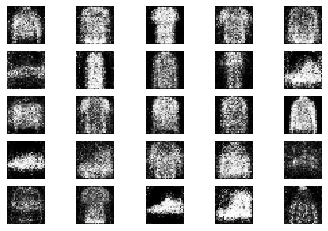

2201 [D loss: 0.502331, acc.: 78.12%] [G loss: 1.184912]
2202 [D loss: 0.499863, acc.: 79.69%] [G loss: 1.195068]
2203 [D loss: 0.535746, acc.: 75.00%] [G loss: 1.320818]
2204 [D loss: 0.547951, acc.: 70.31%] [G loss: 1.356456]
2205 [D loss: 0.467137, acc.: 75.00%] [G loss: 1.274425]
2206 [D loss: 0.547289, acc.: 75.00%] [G loss: 1.233514]
2207 [D loss: 0.507797, acc.: 79.69%] [G loss: 1.210850]
2208 [D loss: 0.531891, acc.: 78.12%] [G loss: 1.208511]
2209 [D loss: 0.544238, acc.: 70.31%] [G loss: 1.319460]
2210 [D loss: 0.511317, acc.: 78.12%] [G loss: 1.337101]
2211 [D loss: 0.569578, acc.: 70.31%] [G loss: 1.253639]
2212 [D loss: 0.496667, acc.: 75.00%] [G loss: 1.259089]
2213 [D loss: 0.571759, acc.: 71.88%] [G loss: 1.366244]
2214 [D loss: 0.551929, acc.: 78.12%] [G loss: 1.186507]
2215 [D loss: 0.465665, acc.: 79.69%] [G loss: 1.348675]
2216 [D loss: 0.510365, acc.: 81.25%] [G loss: 1.379120]
2217 [D loss: 0.518632, acc.: 73.44%] [G loss: 1.312154]
2218 [D loss: 0.597167, acc.: 6

2346 [D loss: 0.524834, acc.: 75.00%] [G loss: 1.336942]
2347 [D loss: 0.625107, acc.: 59.38%] [G loss: 1.331967]
2348 [D loss: 0.541416, acc.: 75.00%] [G loss: 1.272629]
2349 [D loss: 0.529267, acc.: 78.12%] [G loss: 1.303444]
2350 [D loss: 0.497132, acc.: 75.00%] [G loss: 1.425819]
2351 [D loss: 0.585841, acc.: 68.75%] [G loss: 1.179902]
2352 [D loss: 0.548279, acc.: 78.12%] [G loss: 1.214745]
2353 [D loss: 0.505152, acc.: 79.69%] [G loss: 1.240375]
2354 [D loss: 0.521919, acc.: 71.88%] [G loss: 1.128316]
2355 [D loss: 0.515088, acc.: 76.56%] [G loss: 1.125728]
2356 [D loss: 0.525092, acc.: 76.56%] [G loss: 1.055836]
2357 [D loss: 0.376288, acc.: 90.62%] [G loss: 1.263615]
2358 [D loss: 0.533347, acc.: 78.12%] [G loss: 1.175059]
2359 [D loss: 0.542497, acc.: 75.00%] [G loss: 1.290338]
2360 [D loss: 0.438833, acc.: 79.69%] [G loss: 1.318754]
2361 [D loss: 0.465808, acc.: 78.12%] [G loss: 1.161843]
2362 [D loss: 0.456245, acc.: 78.12%] [G loss: 1.335284]
2363 [D loss: 0.497488, acc.: 7

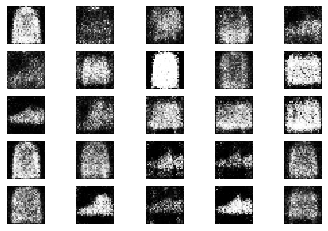

2401 [D loss: 0.530344, acc.: 73.44%] [G loss: 1.271960]
2402 [D loss: 0.530363, acc.: 73.44%] [G loss: 1.236878]
2403 [D loss: 0.658861, acc.: 67.19%] [G loss: 1.208627]
2404 [D loss: 0.544558, acc.: 76.56%] [G loss: 1.485628]
2405 [D loss: 0.568460, acc.: 65.62%] [G loss: 1.119528]
2406 [D loss: 0.553142, acc.: 73.44%] [G loss: 1.186177]
2407 [D loss: 0.610226, acc.: 65.62%] [G loss: 1.088710]
2408 [D loss: 0.544888, acc.: 75.00%] [G loss: 1.057730]
2409 [D loss: 0.561138, acc.: 78.12%] [G loss: 1.116319]
2410 [D loss: 0.396286, acc.: 87.50%] [G loss: 1.114427]
2411 [D loss: 0.533976, acc.: 71.88%] [G loss: 1.166242]
2412 [D loss: 0.533677, acc.: 70.31%] [G loss: 1.085828]
2413 [D loss: 0.567208, acc.: 64.06%] [G loss: 1.289069]
2414 [D loss: 0.613201, acc.: 65.62%] [G loss: 1.168494]
2415 [D loss: 0.484228, acc.: 81.25%] [G loss: 1.297585]
2416 [D loss: 0.607169, acc.: 62.50%] [G loss: 1.331334]
2417 [D loss: 0.522949, acc.: 73.44%] [G loss: 1.295900]
2418 [D loss: 0.567337, acc.: 6

2545 [D loss: 0.578531, acc.: 68.75%] [G loss: 1.222143]
2546 [D loss: 0.559547, acc.: 68.75%] [G loss: 1.268035]
2547 [D loss: 0.476704, acc.: 82.81%] [G loss: 1.308634]
2548 [D loss: 0.593529, acc.: 71.88%] [G loss: 1.204927]
2549 [D loss: 0.611383, acc.: 64.06%] [G loss: 1.087442]
2550 [D loss: 0.442442, acc.: 81.25%] [G loss: 1.092357]
2551 [D loss: 0.492500, acc.: 71.88%] [G loss: 1.174992]
2552 [D loss: 0.465562, acc.: 82.81%] [G loss: 1.279232]
2553 [D loss: 0.471252, acc.: 78.12%] [G loss: 1.174525]
2554 [D loss: 0.540213, acc.: 71.88%] [G loss: 1.238844]
2555 [D loss: 0.453699, acc.: 79.69%] [G loss: 1.157755]
2556 [D loss: 0.650024, acc.: 64.06%] [G loss: 1.274792]
2557 [D loss: 0.567115, acc.: 75.00%] [G loss: 1.278426]
2558 [D loss: 0.468248, acc.: 78.12%] [G loss: 1.381917]
2559 [D loss: 0.624643, acc.: 62.50%] [G loss: 1.209942]
2560 [D loss: 0.538424, acc.: 73.44%] [G loss: 1.287155]
2561 [D loss: 0.520712, acc.: 76.56%] [G loss: 1.271265]
2562 [D loss: 0.510863, acc.: 7

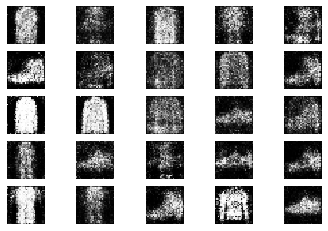

2601 [D loss: 0.585202, acc.: 75.00%] [G loss: 1.237343]
2602 [D loss: 0.460491, acc.: 81.25%] [G loss: 1.131549]
2603 [D loss: 0.562185, acc.: 71.88%] [G loss: 1.024797]
2604 [D loss: 0.583477, acc.: 73.44%] [G loss: 1.247800]
2605 [D loss: 0.416496, acc.: 82.81%] [G loss: 1.229140]
2606 [D loss: 0.631858, acc.: 67.19%] [G loss: 1.164178]
2607 [D loss: 0.505280, acc.: 79.69%] [G loss: 1.237627]
2608 [D loss: 0.490961, acc.: 71.88%] [G loss: 1.196890]
2609 [D loss: 0.401179, acc.: 85.94%] [G loss: 1.274808]
2610 [D loss: 0.566842, acc.: 67.19%] [G loss: 1.155544]
2611 [D loss: 0.503564, acc.: 71.88%] [G loss: 1.206383]
2612 [D loss: 0.525522, acc.: 81.25%] [G loss: 1.111284]
2613 [D loss: 0.487305, acc.: 76.56%] [G loss: 1.220083]
2614 [D loss: 0.434059, acc.: 84.38%] [G loss: 1.303142]
2615 [D loss: 0.488668, acc.: 78.12%] [G loss: 1.333099]
2616 [D loss: 0.488955, acc.: 81.25%] [G loss: 1.301357]
2617 [D loss: 0.572362, acc.: 60.94%] [G loss: 1.048320]
2618 [D loss: 0.431029, acc.: 7

2746 [D loss: 0.535975, acc.: 75.00%] [G loss: 1.228940]
2747 [D loss: 0.552351, acc.: 71.88%] [G loss: 1.251416]
2748 [D loss: 0.465589, acc.: 81.25%] [G loss: 1.125323]
2749 [D loss: 0.453247, acc.: 81.25%] [G loss: 1.146507]
2750 [D loss: 0.582787, acc.: 65.62%] [G loss: 1.165794]
2751 [D loss: 0.495236, acc.: 70.31%] [G loss: 1.118071]
2752 [D loss: 0.406205, acc.: 85.94%] [G loss: 1.145013]
2753 [D loss: 0.488518, acc.: 81.25%] [G loss: 1.194661]
2754 [D loss: 0.540739, acc.: 73.44%] [G loss: 1.114142]
2755 [D loss: 0.517614, acc.: 76.56%] [G loss: 1.157718]
2756 [D loss: 0.412103, acc.: 85.94%] [G loss: 1.387343]
2757 [D loss: 0.464937, acc.: 82.81%] [G loss: 1.221035]
2758 [D loss: 0.615724, acc.: 68.75%] [G loss: 1.233961]
2759 [D loss: 0.516963, acc.: 73.44%] [G loss: 1.323967]
2760 [D loss: 0.546359, acc.: 71.88%] [G loss: 1.269021]
2761 [D loss: 0.488669, acc.: 79.69%] [G loss: 1.118385]
2762 [D loss: 0.478739, acc.: 75.00%] [G loss: 1.252556]
2763 [D loss: 0.553216, acc.: 6

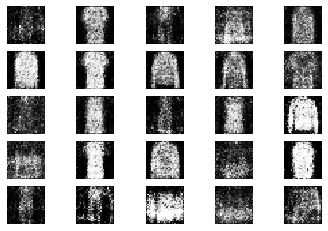

2801 [D loss: 0.513457, acc.: 70.31%] [G loss: 1.341345]
2802 [D loss: 0.533836, acc.: 68.75%] [G loss: 1.313225]
2803 [D loss: 0.523264, acc.: 71.88%] [G loss: 1.308414]
2804 [D loss: 0.605151, acc.: 65.62%] [G loss: 1.183848]
2805 [D loss: 0.553006, acc.: 71.88%] [G loss: 1.054057]
2806 [D loss: 0.586028, acc.: 73.44%] [G loss: 1.229120]
2807 [D loss: 0.502402, acc.: 78.12%] [G loss: 1.237002]
2808 [D loss: 0.560580, acc.: 70.31%] [G loss: 1.185326]
2809 [D loss: 0.548716, acc.: 79.69%] [G loss: 1.222338]
2810 [D loss: 0.502146, acc.: 81.25%] [G loss: 1.340904]
2811 [D loss: 0.538266, acc.: 70.31%] [G loss: 1.265367]
2812 [D loss: 0.537005, acc.: 71.88%] [G loss: 1.318368]
2813 [D loss: 0.538522, acc.: 70.31%] [G loss: 1.301510]
2814 [D loss: 0.594155, acc.: 68.75%] [G loss: 1.211962]
2815 [D loss: 0.594144, acc.: 70.31%] [G loss: 1.220131]
2816 [D loss: 0.531522, acc.: 75.00%] [G loss: 1.263469]
2817 [D loss: 0.508631, acc.: 75.00%] [G loss: 1.265033]
2818 [D loss: 0.501645, acc.: 7

2945 [D loss: 0.449597, acc.: 85.94%] [G loss: 1.248987]
2946 [D loss: 0.512689, acc.: 68.75%] [G loss: 1.080498]
2947 [D loss: 0.568726, acc.: 71.88%] [G loss: 1.180180]
2948 [D loss: 0.613501, acc.: 67.19%] [G loss: 1.202934]
2949 [D loss: 0.511072, acc.: 71.88%] [G loss: 1.228058]
2950 [D loss: 0.587235, acc.: 65.62%] [G loss: 1.256805]
2951 [D loss: 0.443290, acc.: 89.06%] [G loss: 1.184374]
2952 [D loss: 0.510704, acc.: 78.12%] [G loss: 1.217134]
2953 [D loss: 0.545633, acc.: 68.75%] [G loss: 1.190968]
2954 [D loss: 0.472429, acc.: 81.25%] [G loss: 1.230207]
2955 [D loss: 0.551895, acc.: 70.31%] [G loss: 1.301609]
2956 [D loss: 0.583326, acc.: 70.31%] [G loss: 1.318869]
2957 [D loss: 0.534112, acc.: 71.88%] [G loss: 1.474086]
2958 [D loss: 0.572320, acc.: 73.44%] [G loss: 1.354587]
2959 [D loss: 0.613742, acc.: 71.88%] [G loss: 1.300289]
2960 [D loss: 0.532892, acc.: 71.88%] [G loss: 1.172230]
2961 [D loss: 0.543353, acc.: 73.44%] [G loss: 1.196088]
2962 [D loss: 0.486130, acc.: 7

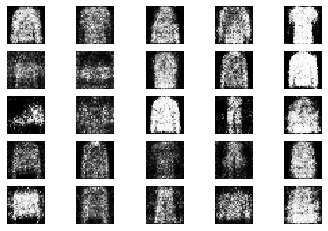

3001 [D loss: 0.509520, acc.: 75.00%] [G loss: 1.132803]
3002 [D loss: 0.600835, acc.: 64.06%] [G loss: 1.219487]
3003 [D loss: 0.549931, acc.: 71.88%] [G loss: 1.201354]
3004 [D loss: 0.553520, acc.: 71.88%] [G loss: 1.109033]
3005 [D loss: 0.530304, acc.: 67.19%] [G loss: 1.063676]
3006 [D loss: 0.504684, acc.: 75.00%] [G loss: 1.193626]
3007 [D loss: 0.539192, acc.: 73.44%] [G loss: 1.150053]
3008 [D loss: 0.504084, acc.: 73.44%] [G loss: 1.296163]
3009 [D loss: 0.538435, acc.: 76.56%] [G loss: 1.229501]
3010 [D loss: 0.512244, acc.: 73.44%] [G loss: 1.252842]
3011 [D loss: 0.498575, acc.: 71.88%] [G loss: 1.145466]
3012 [D loss: 0.511407, acc.: 78.12%] [G loss: 1.284283]
3013 [D loss: 0.616521, acc.: 64.06%] [G loss: 1.218152]
3014 [D loss: 0.523878, acc.: 70.31%] [G loss: 1.413209]
3015 [D loss: 0.524013, acc.: 75.00%] [G loss: 1.359207]
3016 [D loss: 0.527214, acc.: 70.31%] [G loss: 1.260090]
3017 [D loss: 0.539426, acc.: 75.00%] [G loss: 1.147353]
3018 [D loss: 0.491719, acc.: 7

3145 [D loss: 0.555427, acc.: 62.50%] [G loss: 1.267037]
3146 [D loss: 0.509711, acc.: 75.00%] [G loss: 1.121534]
3147 [D loss: 0.499019, acc.: 76.56%] [G loss: 1.257445]
3148 [D loss: 0.414658, acc.: 82.81%] [G loss: 1.238889]
3149 [D loss: 0.554580, acc.: 70.31%] [G loss: 1.301819]
3150 [D loss: 0.423514, acc.: 78.12%] [G loss: 1.193627]
3151 [D loss: 0.518602, acc.: 73.44%] [G loss: 1.472013]
3152 [D loss: 0.631352, acc.: 59.38%] [G loss: 1.095624]
3153 [D loss: 0.585037, acc.: 68.75%] [G loss: 1.230735]
3154 [D loss: 0.547585, acc.: 70.31%] [G loss: 1.276311]
3155 [D loss: 0.500019, acc.: 76.56%] [G loss: 1.358888]
3156 [D loss: 0.540617, acc.: 73.44%] [G loss: 1.249078]
3157 [D loss: 0.461956, acc.: 82.81%] [G loss: 1.197829]
3158 [D loss: 0.594279, acc.: 65.62%] [G loss: 1.283751]
3159 [D loss: 0.629294, acc.: 71.88%] [G loss: 1.054205]
3160 [D loss: 0.599510, acc.: 65.62%] [G loss: 1.142264]
3161 [D loss: 0.542091, acc.: 75.00%] [G loss: 1.134275]
3162 [D loss: 0.553848, acc.: 6

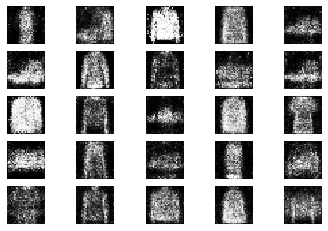

3201 [D loss: 0.489653, acc.: 84.38%] [G loss: 1.317137]
3202 [D loss: 0.531568, acc.: 68.75%] [G loss: 1.080077]
3203 [D loss: 0.592797, acc.: 68.75%] [G loss: 1.133320]
3204 [D loss: 0.512506, acc.: 73.44%] [G loss: 1.209661]
3205 [D loss: 0.554471, acc.: 71.88%] [G loss: 1.191808]
3206 [D loss: 0.658949, acc.: 56.25%] [G loss: 1.130563]
3207 [D loss: 0.568762, acc.: 68.75%] [G loss: 1.177664]
3208 [D loss: 0.481098, acc.: 76.56%] [G loss: 1.229808]
3209 [D loss: 0.610181, acc.: 64.06%] [G loss: 1.215568]
3210 [D loss: 0.396219, acc.: 84.38%] [G loss: 1.251580]
3211 [D loss: 0.543405, acc.: 76.56%] [G loss: 1.301959]
3212 [D loss: 0.550709, acc.: 73.44%] [G loss: 1.213163]
3213 [D loss: 0.602809, acc.: 70.31%] [G loss: 1.022951]
3214 [D loss: 0.610769, acc.: 57.81%] [G loss: 1.119385]
3215 [D loss: 0.520264, acc.: 81.25%] [G loss: 1.306256]
3216 [D loss: 0.595694, acc.: 62.50%] [G loss: 1.172399]
3217 [D loss: 0.461771, acc.: 82.81%] [G loss: 1.131897]
3218 [D loss: 0.596280, acc.: 6

3345 [D loss: 0.490245, acc.: 75.00%] [G loss: 0.946077]
3346 [D loss: 0.579961, acc.: 64.06%] [G loss: 1.252772]
3347 [D loss: 0.473693, acc.: 82.81%] [G loss: 1.086427]
3348 [D loss: 0.480851, acc.: 75.00%] [G loss: 1.379620]
3349 [D loss: 0.534641, acc.: 70.31%] [G loss: 1.083618]
3350 [D loss: 0.678150, acc.: 56.25%] [G loss: 1.170881]
3351 [D loss: 0.522226, acc.: 70.31%] [G loss: 1.272795]
3352 [D loss: 0.566103, acc.: 75.00%] [G loss: 1.136777]
3353 [D loss: 0.693307, acc.: 60.94%] [G loss: 1.230366]
3354 [D loss: 0.581026, acc.: 65.62%] [G loss: 1.189562]
3355 [D loss: 0.517175, acc.: 73.44%] [G loss: 1.240153]
3356 [D loss: 0.506694, acc.: 76.56%] [G loss: 1.292695]
3357 [D loss: 0.479947, acc.: 78.12%] [G loss: 1.157369]
3358 [D loss: 0.515358, acc.: 75.00%] [G loss: 1.226274]
3359 [D loss: 0.515581, acc.: 75.00%] [G loss: 1.212577]
3360 [D loss: 0.564253, acc.: 71.88%] [G loss: 1.143013]
3361 [D loss: 0.491298, acc.: 75.00%] [G loss: 1.226823]
3362 [D loss: 0.573948, acc.: 6

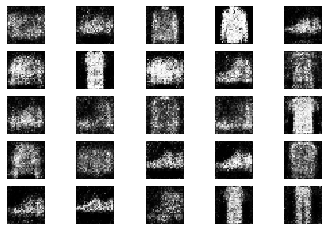

3401 [D loss: 0.559822, acc.: 73.44%] [G loss: 1.203928]
3402 [D loss: 0.529984, acc.: 73.44%] [G loss: 1.297894]
3403 [D loss: 0.573250, acc.: 70.31%] [G loss: 1.183635]
3404 [D loss: 0.599409, acc.: 68.75%] [G loss: 1.258853]
3405 [D loss: 0.530388, acc.: 76.56%] [G loss: 1.020624]
3406 [D loss: 0.557784, acc.: 73.44%] [G loss: 1.370470]
3407 [D loss: 0.601913, acc.: 70.31%] [G loss: 1.248724]
3408 [D loss: 0.611362, acc.: 59.38%] [G loss: 1.170605]
3409 [D loss: 0.587059, acc.: 62.50%] [G loss: 1.102560]
3410 [D loss: 0.526519, acc.: 68.75%] [G loss: 1.365503]
3411 [D loss: 0.520683, acc.: 76.56%] [G loss: 1.298411]
3412 [D loss: 0.595385, acc.: 73.44%] [G loss: 1.187529]
3413 [D loss: 0.522875, acc.: 76.56%] [G loss: 1.059622]
3414 [D loss: 0.555404, acc.: 68.75%] [G loss: 1.138584]
3415 [D loss: 0.535248, acc.: 73.44%] [G loss: 1.012953]
3416 [D loss: 0.563780, acc.: 75.00%] [G loss: 1.277660]
3417 [D loss: 0.519692, acc.: 78.12%] [G loss: 1.151901]
3418 [D loss: 0.498627, acc.: 7

3546 [D loss: 0.486963, acc.: 81.25%] [G loss: 1.272070]
3547 [D loss: 0.536485, acc.: 71.88%] [G loss: 1.362099]
3548 [D loss: 0.639245, acc.: 65.62%] [G loss: 1.160950]
3549 [D loss: 0.592386, acc.: 68.75%] [G loss: 1.126145]
3550 [D loss: 0.588933, acc.: 57.81%] [G loss: 1.442650]
3551 [D loss: 0.537255, acc.: 68.75%] [G loss: 1.106400]
3552 [D loss: 0.584328, acc.: 68.75%] [G loss: 1.320527]
3553 [D loss: 0.575363, acc.: 64.06%] [G loss: 1.217440]
3554 [D loss: 0.661845, acc.: 64.06%] [G loss: 1.115854]
3555 [D loss: 0.473361, acc.: 79.69%] [G loss: 1.274902]
3556 [D loss: 0.574354, acc.: 67.19%] [G loss: 1.141985]
3557 [D loss: 0.548552, acc.: 62.50%] [G loss: 1.234046]
3558 [D loss: 0.486207, acc.: 75.00%] [G loss: 1.147558]
3559 [D loss: 0.528055, acc.: 76.56%] [G loss: 1.245613]
3560 [D loss: 0.503640, acc.: 76.56%] [G loss: 1.147028]
3561 [D loss: 0.506466, acc.: 76.56%] [G loss: 1.210536]
3562 [D loss: 0.519031, acc.: 71.88%] [G loss: 1.455250]
3563 [D loss: 0.487896, acc.: 7

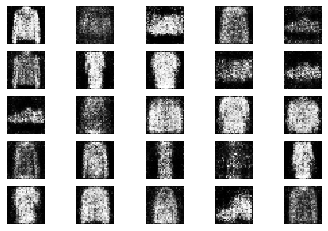

3601 [D loss: 0.529765, acc.: 73.44%] [G loss: 1.283925]
3602 [D loss: 0.495649, acc.: 81.25%] [G loss: 1.243980]
3603 [D loss: 0.537218, acc.: 70.31%] [G loss: 1.024249]
3604 [D loss: 0.477419, acc.: 75.00%] [G loss: 1.018257]
3605 [D loss: 0.500134, acc.: 76.56%] [G loss: 1.184962]
3606 [D loss: 0.471835, acc.: 78.12%] [G loss: 1.208816]
3607 [D loss: 0.653270, acc.: 62.50%] [G loss: 1.284377]
3608 [D loss: 0.494375, acc.: 75.00%] [G loss: 1.349482]
3609 [D loss: 0.547232, acc.: 71.88%] [G loss: 1.489344]
3610 [D loss: 0.460227, acc.: 79.69%] [G loss: 1.397914]
3611 [D loss: 0.563434, acc.: 76.56%] [G loss: 1.500139]
3612 [D loss: 0.534765, acc.: 73.44%] [G loss: 1.452452]
3613 [D loss: 0.477088, acc.: 75.00%] [G loss: 1.363914]
3614 [D loss: 0.683882, acc.: 56.25%] [G loss: 1.194520]
3615 [D loss: 0.547989, acc.: 68.75%] [G loss: 1.074218]
3616 [D loss: 0.600222, acc.: 68.75%] [G loss: 1.100960]
3617 [D loss: 0.491643, acc.: 78.12%] [G loss: 1.157404]
3618 [D loss: 0.489076, acc.: 7

3746 [D loss: 0.608546, acc.: 71.88%] [G loss: 1.191440]
3747 [D loss: 0.515861, acc.: 73.44%] [G loss: 1.322442]
3748 [D loss: 0.509756, acc.: 76.56%] [G loss: 1.289384]
3749 [D loss: 0.574718, acc.: 71.88%] [G loss: 1.214469]
3750 [D loss: 0.514104, acc.: 78.12%] [G loss: 1.155813]
3751 [D loss: 0.531137, acc.: 70.31%] [G loss: 1.362013]
3752 [D loss: 0.549657, acc.: 71.88%] [G loss: 1.222369]
3753 [D loss: 0.587732, acc.: 70.31%] [G loss: 1.236913]
3754 [D loss: 0.568790, acc.: 71.88%] [G loss: 1.125880]
3755 [D loss: 0.526546, acc.: 76.56%] [G loss: 1.133682]
3756 [D loss: 0.485995, acc.: 76.56%] [G loss: 1.190335]
3757 [D loss: 0.489700, acc.: 78.12%] [G loss: 1.173300]
3758 [D loss: 0.501870, acc.: 78.12%] [G loss: 1.294207]
3759 [D loss: 0.501267, acc.: 79.69%] [G loss: 1.034693]
3760 [D loss: 0.519774, acc.: 75.00%] [G loss: 1.209506]
3761 [D loss: 0.523162, acc.: 73.44%] [G loss: 1.069026]
3762 [D loss: 0.695011, acc.: 62.50%] [G loss: 1.037797]
3763 [D loss: 0.590100, acc.: 7

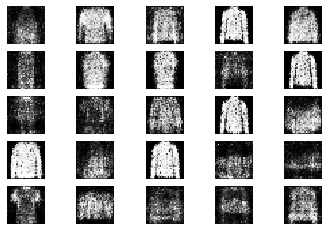

3801 [D loss: 0.549717, acc.: 67.19%] [G loss: 1.043956]
3802 [D loss: 0.608227, acc.: 73.44%] [G loss: 1.219742]
3803 [D loss: 0.625949, acc.: 67.19%] [G loss: 0.974411]
3804 [D loss: 0.688582, acc.: 46.88%] [G loss: 1.064626]
3805 [D loss: 0.622893, acc.: 57.81%] [G loss: 1.196516]
3806 [D loss: 0.520889, acc.: 71.88%] [G loss: 1.154129]
3807 [D loss: 0.476696, acc.: 79.69%] [G loss: 1.146950]
3808 [D loss: 0.517160, acc.: 79.69%] [G loss: 1.275913]
3809 [D loss: 0.631365, acc.: 67.19%] [G loss: 1.117057]
3810 [D loss: 0.539787, acc.: 73.44%] [G loss: 1.095601]
3811 [D loss: 0.594450, acc.: 71.88%] [G loss: 1.019972]
3812 [D loss: 0.484604, acc.: 76.56%] [G loss: 1.141273]
3813 [D loss: 0.592140, acc.: 67.19%] [G loss: 1.290568]
3814 [D loss: 0.589349, acc.: 71.88%] [G loss: 1.059197]
3815 [D loss: 0.440934, acc.: 89.06%] [G loss: 1.075508]
3816 [D loss: 0.515519, acc.: 71.88%] [G loss: 0.955426]
3817 [D loss: 0.496459, acc.: 75.00%] [G loss: 1.183350]
3818 [D loss: 0.617137, acc.: 6

3945 [D loss: 0.521594, acc.: 75.00%] [G loss: 1.193567]
3946 [D loss: 0.590344, acc.: 70.31%] [G loss: 1.321863]
3947 [D loss: 0.618132, acc.: 62.50%] [G loss: 1.343239]
3948 [D loss: 0.564871, acc.: 64.06%] [G loss: 1.350377]
3949 [D loss: 0.499243, acc.: 75.00%] [G loss: 1.274175]
3950 [D loss: 0.621292, acc.: 64.06%] [G loss: 1.198998]
3951 [D loss: 0.549550, acc.: 78.12%] [G loss: 1.272646]
3952 [D loss: 0.510174, acc.: 68.75%] [G loss: 1.038223]
3953 [D loss: 0.536272, acc.: 75.00%] [G loss: 1.337902]
3954 [D loss: 0.516999, acc.: 73.44%] [G loss: 1.242617]
3955 [D loss: 0.558298, acc.: 65.62%] [G loss: 1.058687]
3956 [D loss: 0.602472, acc.: 71.88%] [G loss: 1.095946]
3957 [D loss: 0.556885, acc.: 68.75%] [G loss: 1.085446]
3958 [D loss: 0.523612, acc.: 76.56%] [G loss: 0.965627]
3959 [D loss: 0.601401, acc.: 60.94%] [G loss: 1.227715]
3960 [D loss: 0.504642, acc.: 75.00%] [G loss: 1.298944]
3961 [D loss: 0.497554, acc.: 81.25%] [G loss: 1.161683]
3962 [D loss: 0.596251, acc.: 7

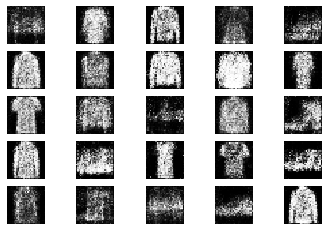

4001 [D loss: 0.574747, acc.: 73.44%] [G loss: 1.201722]
4002 [D loss: 0.575981, acc.: 64.06%] [G loss: 1.202425]
4003 [D loss: 0.479786, acc.: 75.00%] [G loss: 1.107104]
4004 [D loss: 0.635632, acc.: 67.19%] [G loss: 1.097654]
4005 [D loss: 0.614302, acc.: 62.50%] [G loss: 1.099648]
4006 [D loss: 0.462839, acc.: 78.12%] [G loss: 1.224182]
4007 [D loss: 0.569607, acc.: 71.88%] [G loss: 1.195785]
4008 [D loss: 0.468009, acc.: 82.81%] [G loss: 1.261085]
4009 [D loss: 0.593431, acc.: 71.88%] [G loss: 1.093771]
4010 [D loss: 0.507545, acc.: 71.88%] [G loss: 1.227932]
4011 [D loss: 0.630153, acc.: 57.81%] [G loss: 1.155802]
4012 [D loss: 0.501279, acc.: 70.31%] [G loss: 1.261904]
4013 [D loss: 0.500400, acc.: 79.69%] [G loss: 1.215899]
4014 [D loss: 0.519908, acc.: 75.00%] [G loss: 1.243594]
4015 [D loss: 0.554330, acc.: 75.00%] [G loss: 1.175339]
4016 [D loss: 0.521399, acc.: 71.88%] [G loss: 1.136967]
4017 [D loss: 0.558048, acc.: 71.88%] [G loss: 1.110624]
4018 [D loss: 0.575867, acc.: 6

4146 [D loss: 0.508291, acc.: 75.00%] [G loss: 1.164442]
4147 [D loss: 0.648849, acc.: 59.38%] [G loss: 0.985639]
4148 [D loss: 0.555064, acc.: 67.19%] [G loss: 1.157391]
4149 [D loss: 0.483456, acc.: 76.56%] [G loss: 1.254951]
4150 [D loss: 0.598158, acc.: 68.75%] [G loss: 1.267331]
4151 [D loss: 0.598349, acc.: 64.06%] [G loss: 1.229947]
4152 [D loss: 0.546474, acc.: 65.62%] [G loss: 1.142714]
4153 [D loss: 0.636021, acc.: 64.06%] [G loss: 1.068277]
4154 [D loss: 0.568451, acc.: 71.88%] [G loss: 1.189004]
4155 [D loss: 0.616474, acc.: 64.06%] [G loss: 1.075480]
4156 [D loss: 0.588664, acc.: 67.19%] [G loss: 1.089640]
4157 [D loss: 0.535539, acc.: 71.88%] [G loss: 1.177639]
4158 [D loss: 0.515571, acc.: 73.44%] [G loss: 1.271686]
4159 [D loss: 0.576686, acc.: 70.31%] [G loss: 1.241874]
4160 [D loss: 0.492764, acc.: 71.88%] [G loss: 1.153957]
4161 [D loss: 0.609033, acc.: 75.00%] [G loss: 1.054067]
4162 [D loss: 0.612384, acc.: 64.06%] [G loss: 1.134652]
4163 [D loss: 0.500688, acc.: 7

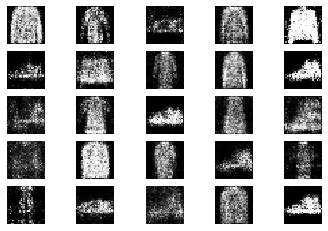

4201 [D loss: 0.561780, acc.: 68.75%] [G loss: 1.068916]
4202 [D loss: 0.601344, acc.: 62.50%] [G loss: 1.037560]
4203 [D loss: 0.543992, acc.: 76.56%] [G loss: 1.240790]
4204 [D loss: 0.583790, acc.: 68.75%] [G loss: 1.157576]
4205 [D loss: 0.558702, acc.: 76.56%] [G loss: 1.130846]
4206 [D loss: 0.601901, acc.: 68.75%] [G loss: 1.136789]
4207 [D loss: 0.549405, acc.: 75.00%] [G loss: 1.010296]
4208 [D loss: 0.522401, acc.: 71.88%] [G loss: 1.224994]
4209 [D loss: 0.690891, acc.: 59.38%] [G loss: 1.136071]
4210 [D loss: 0.582721, acc.: 67.19%] [G loss: 1.079554]
4211 [D loss: 0.520937, acc.: 73.44%] [G loss: 1.092759]
4212 [D loss: 0.524332, acc.: 65.62%] [G loss: 1.055085]
4213 [D loss: 0.526115, acc.: 78.12%] [G loss: 1.154802]
4214 [D loss: 0.620781, acc.: 64.06%] [G loss: 1.175116]
4215 [D loss: 0.652750, acc.: 62.50%] [G loss: 1.320016]
4216 [D loss: 0.548985, acc.: 75.00%] [G loss: 1.366975]
4217 [D loss: 0.628493, acc.: 60.94%] [G loss: 1.052518]
4218 [D loss: 0.599049, acc.: 6

4346 [D loss: 0.547643, acc.: 71.88%] [G loss: 1.283818]
4347 [D loss: 0.507272, acc.: 75.00%] [G loss: 1.311505]
4348 [D loss: 0.461844, acc.: 79.69%] [G loss: 1.321129]
4349 [D loss: 0.534954, acc.: 71.88%] [G loss: 1.466277]
4350 [D loss: 0.574793, acc.: 71.88%] [G loss: 1.206730]
4351 [D loss: 0.539480, acc.: 78.12%] [G loss: 1.247982]
4352 [D loss: 0.511849, acc.: 78.12%] [G loss: 1.224778]
4353 [D loss: 0.607056, acc.: 60.94%] [G loss: 1.118083]
4354 [D loss: 0.577521, acc.: 71.88%] [G loss: 1.008574]
4355 [D loss: 0.574582, acc.: 70.31%] [G loss: 1.243702]
4356 [D loss: 0.486223, acc.: 79.69%] [G loss: 1.234104]
4357 [D loss: 0.569429, acc.: 65.62%] [G loss: 1.144310]
4358 [D loss: 0.570562, acc.: 67.19%] [G loss: 1.142193]
4359 [D loss: 0.594569, acc.: 68.75%] [G loss: 1.118769]
4360 [D loss: 0.483442, acc.: 73.44%] [G loss: 1.231223]
4361 [D loss: 0.633954, acc.: 67.19%] [G loss: 1.104332]
4362 [D loss: 0.547451, acc.: 71.88%] [G loss: 1.126238]
4363 [D loss: 0.574968, acc.: 6

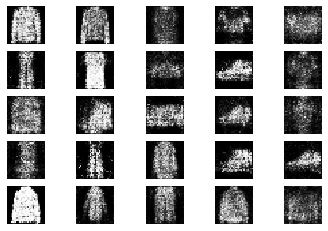

4401 [D loss: 0.602472, acc.: 64.06%] [G loss: 1.129225]
4402 [D loss: 0.554925, acc.: 70.31%] [G loss: 1.228963]
4403 [D loss: 0.626973, acc.: 65.62%] [G loss: 1.173346]
4404 [D loss: 0.598733, acc.: 73.44%] [G loss: 1.091995]
4405 [D loss: 0.547793, acc.: 76.56%] [G loss: 1.032328]
4406 [D loss: 0.565125, acc.: 65.62%] [G loss: 1.258013]
4407 [D loss: 0.550504, acc.: 78.12%] [G loss: 1.290336]
4408 [D loss: 0.559847, acc.: 73.44%] [G loss: 1.242982]
4409 [D loss: 0.553880, acc.: 70.31%] [G loss: 1.072572]
4410 [D loss: 0.536777, acc.: 73.44%] [G loss: 1.283912]
4411 [D loss: 0.504196, acc.: 73.44%] [G loss: 1.325669]
4412 [D loss: 0.700464, acc.: 57.81%] [G loss: 1.121122]
4413 [D loss: 0.509455, acc.: 79.69%] [G loss: 1.136401]
4414 [D loss: 0.660070, acc.: 65.62%] [G loss: 1.037086]
4415 [D loss: 0.494703, acc.: 82.81%] [G loss: 1.135737]
4416 [D loss: 0.607439, acc.: 65.62%] [G loss: 0.995526]
4417 [D loss: 0.570502, acc.: 68.75%] [G loss: 1.250624]
4418 [D loss: 0.526156, acc.: 7

4547 [D loss: 0.629431, acc.: 54.69%] [G loss: 1.127746]
4548 [D loss: 0.505616, acc.: 78.12%] [G loss: 1.316576]
4549 [D loss: 0.499667, acc.: 82.81%] [G loss: 1.319605]
4550 [D loss: 0.544097, acc.: 71.88%] [G loss: 1.486024]
4551 [D loss: 0.609626, acc.: 59.38%] [G loss: 1.239351]
4552 [D loss: 0.616863, acc.: 67.19%] [G loss: 1.164950]
4553 [D loss: 0.618865, acc.: 70.31%] [G loss: 1.163280]
4554 [D loss: 0.506503, acc.: 82.81%] [G loss: 1.174695]
4555 [D loss: 0.579108, acc.: 70.31%] [G loss: 1.024953]
4556 [D loss: 0.574646, acc.: 64.06%] [G loss: 1.093544]
4557 [D loss: 0.696083, acc.: 57.81%] [G loss: 1.095657]
4558 [D loss: 0.487034, acc.: 70.31%] [G loss: 1.293378]
4559 [D loss: 0.516805, acc.: 75.00%] [G loss: 1.148635]
4560 [D loss: 0.588221, acc.: 67.19%] [G loss: 1.306691]
4561 [D loss: 0.576264, acc.: 73.44%] [G loss: 1.171743]
4562 [D loss: 0.515760, acc.: 75.00%] [G loss: 1.182122]
4563 [D loss: 0.512938, acc.: 70.31%] [G loss: 1.233849]
4564 [D loss: 0.558031, acc.: 7

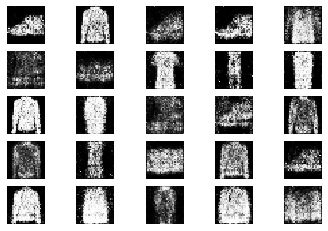

4601 [D loss: 0.515715, acc.: 73.44%] [G loss: 1.260607]
4602 [D loss: 0.518673, acc.: 70.31%] [G loss: 1.282602]
4603 [D loss: 0.584860, acc.: 67.19%] [G loss: 1.235300]
4604 [D loss: 0.497551, acc.: 76.56%] [G loss: 1.339476]
4605 [D loss: 0.577526, acc.: 70.31%] [G loss: 1.198254]
4606 [D loss: 0.467179, acc.: 82.81%] [G loss: 1.092374]
4607 [D loss: 0.489498, acc.: 84.38%] [G loss: 1.100580]
4608 [D loss: 0.616307, acc.: 65.62%] [G loss: 1.199471]
4609 [D loss: 0.516864, acc.: 78.12%] [G loss: 1.160200]
4610 [D loss: 0.559866, acc.: 73.44%] [G loss: 1.221785]
4611 [D loss: 0.565898, acc.: 62.50%] [G loss: 1.049444]
4612 [D loss: 0.531922, acc.: 67.19%] [G loss: 1.236032]
4613 [D loss: 0.586816, acc.: 68.75%] [G loss: 1.213787]
4614 [D loss: 0.599599, acc.: 64.06%] [G loss: 1.127942]
4615 [D loss: 0.522995, acc.: 70.31%] [G loss: 1.049576]
4616 [D loss: 0.481511, acc.: 71.88%] [G loss: 1.266649]
4617 [D loss: 0.539918, acc.: 75.00%] [G loss: 1.283334]
4618 [D loss: 0.513573, acc.: 7

4747 [D loss: 0.545232, acc.: 70.31%] [G loss: 1.070088]
4748 [D loss: 0.589013, acc.: 76.56%] [G loss: 1.253361]
4749 [D loss: 0.520366, acc.: 71.88%] [G loss: 1.258151]
4750 [D loss: 0.528783, acc.: 79.69%] [G loss: 1.391565]
4751 [D loss: 0.515549, acc.: 75.00%] [G loss: 1.280641]
4752 [D loss: 0.566121, acc.: 78.12%] [G loss: 1.177926]
4753 [D loss: 0.581814, acc.: 68.75%] [G loss: 1.085973]
4754 [D loss: 0.533860, acc.: 75.00%] [G loss: 1.227082]
4755 [D loss: 0.643960, acc.: 68.75%] [G loss: 1.130496]
4756 [D loss: 0.568173, acc.: 67.19%] [G loss: 1.438351]
4757 [D loss: 0.504573, acc.: 75.00%] [G loss: 1.438320]
4758 [D loss: 0.627572, acc.: 62.50%] [G loss: 1.314080]
4759 [D loss: 0.555249, acc.: 64.06%] [G loss: 1.305186]
4760 [D loss: 0.570515, acc.: 71.88%] [G loss: 1.133766]
4761 [D loss: 0.543134, acc.: 70.31%] [G loss: 1.026181]
4762 [D loss: 0.489319, acc.: 79.69%] [G loss: 1.132310]
4763 [D loss: 0.677859, acc.: 62.50%] [G loss: 1.050850]
4764 [D loss: 0.597461, acc.: 6

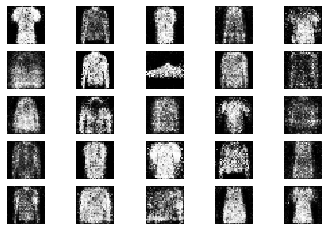

4801 [D loss: 0.454476, acc.: 78.12%] [G loss: 1.117488]
4802 [D loss: 0.673324, acc.: 65.62%] [G loss: 1.114263]
4803 [D loss: 0.698444, acc.: 54.69%] [G loss: 0.982877]
4804 [D loss: 0.634942, acc.: 57.81%] [G loss: 1.033046]
4805 [D loss: 0.645968, acc.: 60.94%] [G loss: 1.107359]
4806 [D loss: 0.492515, acc.: 79.69%] [G loss: 1.205722]
4807 [D loss: 0.564382, acc.: 70.31%] [G loss: 1.234249]
4808 [D loss: 0.573229, acc.: 71.88%] [G loss: 1.262711]
4809 [D loss: 0.552700, acc.: 73.44%] [G loss: 1.198696]
4810 [D loss: 0.586847, acc.: 67.19%] [G loss: 1.229973]
4811 [D loss: 0.564628, acc.: 76.56%] [G loss: 1.279245]
4812 [D loss: 0.575326, acc.: 70.31%] [G loss: 1.143937]
4813 [D loss: 0.595961, acc.: 65.62%] [G loss: 1.199447]
4814 [D loss: 0.602818, acc.: 65.62%] [G loss: 1.159164]
4815 [D loss: 0.558122, acc.: 70.31%] [G loss: 1.184013]
4816 [D loss: 0.597870, acc.: 64.06%] [G loss: 1.214958]
4817 [D loss: 0.571415, acc.: 68.75%] [G loss: 1.134563]
4818 [D loss: 0.581664, acc.: 7

4947 [D loss: 0.701851, acc.: 59.38%] [G loss: 1.110687]
4948 [D loss: 0.680074, acc.: 57.81%] [G loss: 1.267592]
4949 [D loss: 0.499154, acc.: 73.44%] [G loss: 1.145144]
4950 [D loss: 0.620358, acc.: 73.44%] [G loss: 1.077191]
4951 [D loss: 0.565390, acc.: 75.00%] [G loss: 1.072452]
4952 [D loss: 0.553548, acc.: 70.31%] [G loss: 1.154608]
4953 [D loss: 0.624441, acc.: 64.06%] [G loss: 1.074991]
4954 [D loss: 0.512150, acc.: 75.00%] [G loss: 1.228590]
4955 [D loss: 0.574228, acc.: 68.75%] [G loss: 1.157467]
4956 [D loss: 0.545358, acc.: 70.31%] [G loss: 1.301746]
4957 [D loss: 0.563683, acc.: 75.00%] [G loss: 1.276274]
4958 [D loss: 0.596955, acc.: 68.75%] [G loss: 1.087891]
4959 [D loss: 0.528190, acc.: 76.56%] [G loss: 1.321350]
4960 [D loss: 0.577257, acc.: 67.19%] [G loss: 1.142344]
4961 [D loss: 0.484456, acc.: 78.12%] [G loss: 1.231254]
4962 [D loss: 0.563429, acc.: 71.88%] [G loss: 1.102205]
4963 [D loss: 0.512250, acc.: 73.44%] [G loss: 0.991883]
4964 [D loss: 0.546390, acc.: 7

In [14]:
train(epochs=5000, batch_size=32, sample_interval=200)

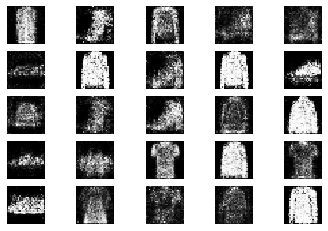

In [15]:
sample_images(save=1)

In [16]:
save_original_dataset_imgs()